##**Redes Neuronales Recurrentes (RNN)**

#**PyTorch VII**
Autor: Jheremy Reyes,

estudiante de matemáticas,

Universidad El Bosque

RNN.avif

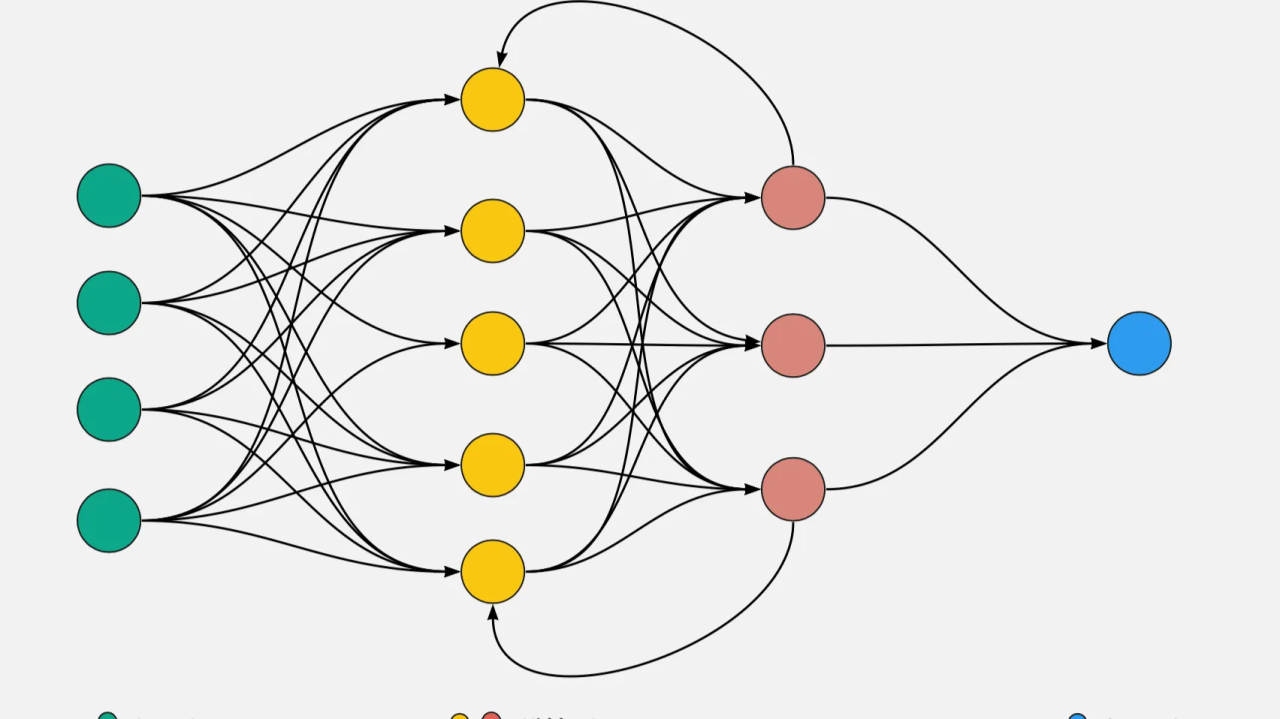

**Redes Neuronales Recurrentes (RNN) en PyTorch**

Las RNNs (Recurrent Neural Networks) son una clase especial de redes neuronales que permiten el manejo de secuencias de datos. A diferencia de las redes tradicionales (como las feedforward), las RNNs poseen una memoria interna que les permite almacenar información sobre entradas anteriores en la secuencia.

Esto es esencial para tareas como:

Predicción de texto o caracteres.
Traducción automática.
Reconocimiento de voz.
Series temporales financieras o médicas.
En PyTorch, estas redes pueden implementarse con módulos como nn.RNN, nn.LSTM o nn.GRU, cada uno con capacidades particulares para manejar dependencias de corto o largo plazo en las secuencias.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

Usando dispositivo: cuda


**Preparación de los datos**

Antes de construir una red neuronal, debemos transformar nuestros datos crudos (en este caso, un texto plano) en un formato que la red pueda entender.

Los pasos comunes incluyen:

Crear un vocabulario: una lista de todos los caracteres únicos presentes en el texto.
Codificar los caracteres: se asigna un número entero a cada carácter.
Generar pares de entrenamiento: se toman fragmentos de texto de longitud fija como entrada y se asocia el siguiente carácter como salida deseada (etiqueta).
Por ejemplo, si la secuencia es "hola mun", se espera que el modelo prediga "d".
Esto genera un conjunto de entrenamiento supervisado para que la red aprenda las transiciones de caracteres.

In [ ]:
# Texto base simple para entrenamiento
texto = "hola mundo aprendiendo redes neuronales recurrentes con pytorch"

# Crear vocabulario
chars = sorted(list(set(texto)))
vocab_size = len(chars)
char2idx = {ch: i for i, ch in enumerate(chars)}
idx2char = {i: ch for i, ch in enumerate(chars)}

# Secuencia de entrada y objetivo
seq_length = 10
step = 1
X, y = [], []
for i in range(0, len(texto) - seq_length, step):
    X.append([char2idx[ch] for ch in texto[i:i + seq_length]])
    y.append(char2idx[texto[i + seq_length]])

X = torch.tensor(X, dtype=torch.long)
y = torch.tensor(y, dtype=torch.long)

**Definición del modelo RNN**

El modelo se construye usando las siguientes capas:

Embedding: convierte los índices enteros en vectores densos que representan mejor la semántica de los caracteres.
RNN: esta es la capa recurrente que mantiene el estado oculto y procesa las entradas secuencialmente.
Fully Connected (Linear): transforma la salida de la RNN en predicciones sobre el espacio del vocabulario.
En código, esto se implementa con nn.Embedding, nn.RNN y nn.Linear.

In [ ]:
class RNNModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super(RNNModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x):
        x = self.embedding(x)
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])  # última salida
        return out

embedding_dim = 32
hidden_dim = 64
model = RNNModel(vocab_size, embedding_dim, hidden_dim).to(device)

**Función de pérdida y optimizador**

Para entrenar el modelo, necesitamos definir:

Función de pérdida: usamos CrossEntropyLoss, que es ideal para clasificación multiclase (cada carácter es una clase).
Optimizador: se utiliza el algoritmo Adam, una variante eficiente del descenso de gradiente, para actualizar los pesos del modelo durante el entrenamiento.
Estas funciones guían el aprendizaje del modelo y minimizan la diferencia entre las predicciones y los valores verdaderos.

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

**Entrenamiento del modelo**

Durante el entrenamiento:

Se realiza una pasada del conjunto de datos completo por el modelo (una época).
Para cada paso, se calcula la salida del modelo, la pérdida y se actualizan los pesos con retropropagación.
Se registra la pérdida en cada época para visualizar posteriormente el progreso del entrenamiento.
Se recomienda entrenar por varias épocas para que el modelo capture correctamente los patrones del texto.

In [ ]:

n_epochs = 100
losses = []

for epoch in range(n_epochs):
    model.train()
    inputs = X.to(device)
    targets = y.to(device)

    outputs = model(inputs)
    loss = criterion(outputs, targets)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.item())
    if (epoch + 1) % 10 == 0:
        print(f"Época {epoch+1}/{n_epochs}, Pérdida: {loss.item():.4f}")

Época 10/100, Pérdida: 0.7113
Época 20/100, Pérdida: 0.0825
Época 30/100, Pérdida: 0.0127
Época 40/100, Pérdida: 0.0045
Época 50/100, Pérdida: 0.0026
Época 60/100, Pérdida: 0.0019
Época 70/100, Pérdida: 0.0015
Época 80/100, Pérdida: 0.0013
Época 90/100, Pérdida: 0.0012
Época 100/100, Pérdida: 0.0010


**Generación de texto con la RNN entrenada**

Una vez entrenado, el modelo puede generar texto a partir de una semilla dada (por ejemplo, "hola mun"). A partir de esta entrada:

Se predice el siguiente carácter.
Se agrega al texto generado.
Se actualiza la entrada para incluir el nuevo carácter y se repite el proceso.
Esto permite crear cadenas de texto de longitud arbitraria, que conservan el estilo y estructura del texto original.

In [ ]:

def generar_texto(modelo, semilla, longitud):
    modelo.eval()
    generated = semilla
    input_seq = [char2idx[ch] for ch in semilla]
    input_seq = torch.tensor(input_seq, dtype=torch.long).unsqueeze(0).to(device)

    for _ in range(longitud):
        with torch.no_grad():
            output = modelo(input_seq)
            pred_idx = torch.argmax(output, dim=1).item()
            pred_char = idx2char[pred_idx]
            generated += pred_char
            # Actualizar la secuencia de entrada
            input_seq = torch.cat([input_seq[:, 1:], torch.tensor([[pred_idx]], device=device)], dim=1)

    return generated

print("\nTexto generado:")
print(generar_texto(model, "hola mundo", 100))


Texto generado:
hola mundo aprendiendo redes neuronales recurrentes con pytorchntes con pytorchntes con pytorchntes con pytorc


**Visualización de resultados**

inalmente, se grafican las pérdidas por época usando matplotlib. Esta visualización permite:

Verificar si el modelo está aprendiendo (la pérdida debe disminuir).
Identificar si hay sobreajuste o problemas de convergencia.
También se imprime una muestra del texto generado para evaluar cualitativamente el desempeño del modelo.

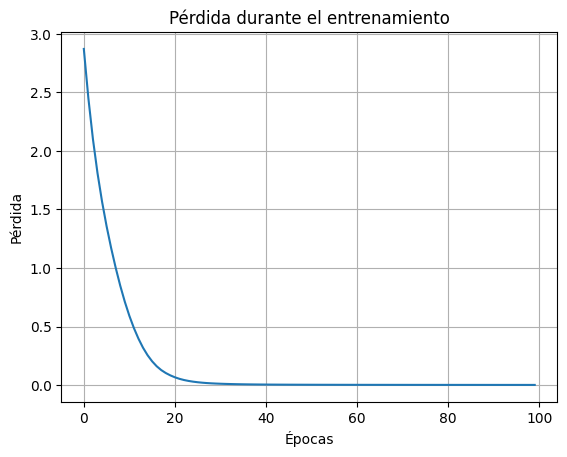

In [ ]:
plt.plot(losses)
plt.title("Pérdida durante el entrenamiento")
plt.xlabel("Épocas")
plt.ylabel("Pérdida")
plt.grid(True)
plt.show()

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer
from itertools import islice

# Paso 1: Tokenizer de HuggingFace
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

# Paso 2: Dataset de ejemplo
class SimpleTextDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        return self.texts[idx], self.labels[idx]

# Datos de prueba
texts = ["This is a test", "PyTorch is great", "Transformers are powerful"]
labels = [0, 1, 1]

# Crear dataset y dataloader
data_train = SimpleTextDataset(texts, labels)
data_loader = DataLoader(data_train, batch_size=1, shuffle=False)

# Paso 3: Mostrar primeros 3 elementos con tokenización
for idx, (text, label) in enumerate(islice(data_loader, 3)):
    text_str = text[0] if isinstance(text, list) or isinstance(text, tuple) else text
    tokens = tokenizer.encode(text_str, add_special_tokens=True)
    print(f"Label: {label.item()} | Tokens: {tokens}")


Label: 0 | Tokens: [101, 2023, 2003, 1037, 3231, 102]
Label: 1 | Tokens: [101, 1052, 22123, 2953, 2818, 2003, 2307, 102]
Label: 1 | Tokens: [101, 19081, 2024, 3928, 102]


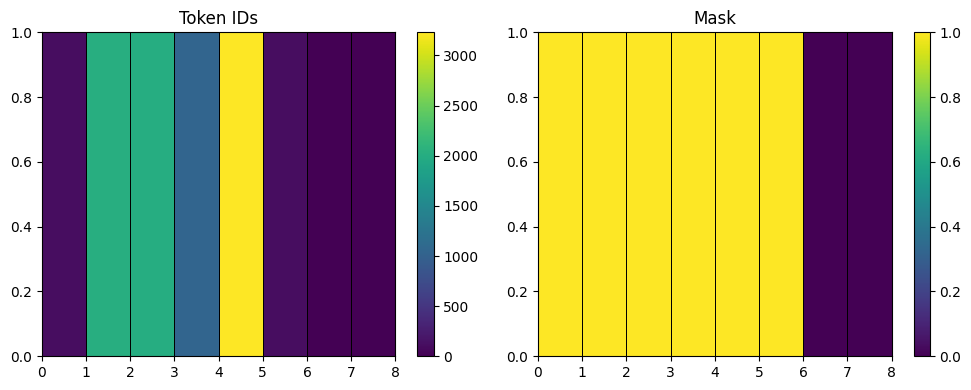

In [ ]:
import torch
import matplotlib.pyplot as plt

# Supongamos que example_tokens es un tensor de tokens de entrada
example_tokens = torch.tensor([[101, 2023, 2003, 1037, 3231, 102, 0, 0]])

# Convertir a numpy si es necesario para graficar
tokens_np = example_tokens.numpy()

plt.figure(figsize=(10, 4))

# Subplot 1: los IDs de los tokens
plt.subplot(1, 2, 1)
plt.pcolormesh(tokens_np, edgecolors='k', linewidth=0.5)
plt.title('Token IDs')
plt.colorbar()

# Subplot 2: la máscara (1 donde el token es diferente de 0)
plt.subplot(1, 2, 2)
plt.pcolormesh((tokens_np != 0), edgecolors='k', linewidth=0.5)
plt.title('Mask')
plt.colorbar()

plt.tight_layout()
plt.show()


In [ ]:
import torch
import torch.nn as nn

class LSTMTextModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim=64, lstm_hidden=32):
        super(LSTMTextModel, self).__init__()
        # Capa embedding
        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_dim)

        # LSTM con return_sequences=True -> batch_first=True para facilitar
        self.lstm1 = nn.LSTM(input_size=embedding_dim, hidden_size=lstm_hidden, batch_first=True)

        # LSTM sin return_sequences (solo output final)
        self.lstm2 = nn.LSTM(input_size=lstm_hidden, hidden_size=lstm_hidden, batch_first=True)

        # Capa densa final (salida escalar)
        self.fc = nn.Linear(lstm_hidden, 1)

    def forward(self, x):
        # x: tensor de enteros con shape (batch_size, seq_len)
        x = self.embedding(x)  # (batch_size, seq_len, embedding_dim)

        lstm_out, _ = self.lstm1(x)  # (batch_size, seq_len, lstm_hidden)
        lstm_out2, (hn, cn) = self.lstm2(lstm_out)  # (batch_size, seq_len, lstm_hidden)

        # Tomamos la salida del último paso temporal para cada batch
        # hn tiene shape (num_layers * num_directions, batch, hidden_size)
        # Aquí num_layers=1 y num_directions=1 => hn shape = (1, batch, lstm_hidden)
        final_hidden = hn.squeeze(0)  # (batch, lstm_hidden)

        output = self.fc(final_hidden)  # (batch, 1)
        return output

# Parámetros (debes definir max_vocab_size)
max_vocab_size = 10000

model = LSTMTextModel(vocab_size=max_vocab_size+1)
print(model)


LSTMTextModel(
  (embedding): Embedding(10001, 64)
  (lstm1): LSTM(64, 32, batch_first=True)
  (lstm2): LSTM(32, 32, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)


In [ ]:
import os
print(os.getcwd())  # directorio actual de trabajo
print(os.listdir())  # qué carpetas hay aquí


/content
['.config', 'sample_data']


In [ ]:
if os.path.exists(train_dir):
    print(os.listdir(train_dir))
else:
    print(f"Directorio {train_dir} no existe")


Directorio aclImdb/train no existe


In [ ]:
import os
import shutil
from pathlib import Path

# 1. Descargar y descomprimir el dataset IMDB
if not os.path.exists('aclImdb'):
    !wget https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
    !tar -xf aclImdb_v1.tar.gz
    print("Dataset descargado y descomprimido")

# 2. Verificar la estructura y eliminar carpeta 'unsup' si existe
train_dir = 'aclImdb/train'
remove_dir = os.path.join(train_dir, 'unsup')

if os.path.exists(remove_dir):
    shutil.rmtree(remove_dir)
    print(f"Eliminada la carpeta: {remove_dir}")

print(f"Contenido de {train_dir}: {os.listdir(train_dir)}")

# 3. Crear Dataset personalizado en PyTorch para leer textos desde directorios

from torch.utils.data import Dataset, DataLoader
import torch

class TextDataset(Dataset):
    def __init__(self, directory):
        self.samples = []
        self.labels = []
        self.label_map = {'pos': 1, 'neg': 0}
        for label_name in ['pos', 'neg']:
            dir_path = os.path.join(directory, label_name)
            for fname in os.listdir(dir_path):
                file_path = os.path.join(dir_path, fname)
                with open(file_path, encoding='utf-8') as f:
                    text = f.read()
                self.samples.append(text)
                self.labels.append(self.label_map[label_name])

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx], self.labels[idx]

# 4. Instanciar datasets y dataloaders
batch_size = 32
train_dataset = TextDataset(train_dir)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# 5. Mostrar algunos ejemplos
for i, (texts, labels) in enumerate(train_loader):
    for j in range(min(3, len(texts))):
        print(f"Review: {texts[j][:200]}...")  # Muestra primeros 200 caracteres
        print(f"Label: {labels[j].item()}")
    break


--2025-05-20 19:00:02--  https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84125825 (80M) [application/x-gzip]
Saving to: ‘aclImdb_v1.tar.gz’

aclImdb_v1.tar.gz   100%[===================>]  80.23M  16.7MB/s    in 5.0s    

2025-05-20 19:00:07 (15.9 MB/s) - ‘aclImdb_v1.tar.gz’ saved [84125825/84125825]

Dataset descargado y descomprimido
Eliminada la carpeta: aclImdb/train/unsup
Contenido de aclImdb/train: ['labeledBow.feat', 'neg', 'urls_unsup.txt', 'pos', 'urls_neg.txt', 'urls_pos.txt', 'unsupBow.feat']
Review: I usually come on this website prior to going to the movies, as I like to see what other people think of the movie. I read many reviews which said 'thriller not a horror movie'. This prompted me to gi...
Label: 0
Review: If you thought that the original from 83 was bad th

In [ ]:
!pip install torch==2.0.1+cu117 torchvision==0.15.2+cu117 torchaudio==2.0.2+cu117 --index-url https://download.pytorch.org/whl/cu117
!pip install torchtext==0.15.2


Looking in indexes: https://download.pytorch.org/whl/cu117
  Using cached https://download.pytorch.org/whl/cu117/torch-2.0.1%2Bcu117-cp311-cp311-linux_x86_64.whl (1843.9 MB)
  Using cached https://download.pytorch.org/whl/cu117/torchvision-0.15.2%2Bcu117-cp311-cp311-linux_x86_64.whl (6.1 MB)
  Using cached https://download.pytorch.org/whl/cu117/torchaudio-2.0.2%2Bcu117-cp311-cp311-linux_x86_64.whl (4.4 MB)
  Using cached https://download.pytorch.org/whl/triton-2.0.0-1-cp311-cp311-manylinux2014_x86_64.manylinux_2_17_x86_64.whl (63.3 MB)
  Attempting uninstall: triton
    Found existing installation: triton 3.3.0
    Uninstalling triton-3.3.0:
      Successfully uninstalled triton-3.3.0


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 32.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 115.3 MB/s eta 0:00:00
  Attempting uninstall: torchdata
    Found existing installation: torchdata 0.11.0
    Uninstalling torchdata-0.11.0:
      Successfully uninstalled torchdata-0.11.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtune 0.6.1 requires torchdata==0.11.0, but you have torchdata 0.6.1 which is incompatible.


In [ ]:
import re
import string
import torch
from torch.utils.data import DataLoader
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

# 1. Función de limpieza personalizada similar a 'custom_standardization'
def custom_standardization(text):
    text = text.lower()
    text = re.sub(r'<br\s*/?>', ' ', text)  # reemplaza <br /> por espacio
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)  # elimina puntuación
    return text

# 2. Dataset ejemplo (supón que tienes lista de textos y etiquetas)
texts = ["I loved this movie! <br /> So good.", "Terrible film... never again!"]
labels = [1, 0]

# 3. Aplicar limpieza a cada texto
clean_texts = [custom_standardization(t) for t in texts]

# 4. Tokenizador simple (por palabras)
tokenizer = get_tokenizer('basic_english')

# 5. Construir vocabulario a partir de todos los tokens del dataset
def yield_tokens(data_iter):
    for text in data_iter:
        yield tokenizer(text)

vocab = build_vocab_from_iterator(yield_tokens(clean_texts), max_tokens=10000, specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"])  # tokens fuera de vocabulario van a <unk>

# 6. Función para vectorizar texto (tokenizar y mapear a enteros)
def vectorize_text(text):
    cleaned = custom_standardization(text)
    tokens = tokenizer(cleaned)
    token_ids = vocab(tokens)
    # Padding o truncamiento a longitud fija 250
    max_len = 250
    if len(token_ids) > max_len:
        token_ids = token_ids[:max_len]
    else:
        token_ids += [0] * (max_len - len(token_ids))
    return torch.tensor(token_ids)

# 7. Prueba con el primer texto
print("Original:", texts[0])
print("Vectorizado:", vectorize_text(texts[0]))


Original: I loved this movie! <br /> So good.
Vectorizado: tensor([ 4,  5, 10,  6,  8,  3,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py", line 37, in <module>
    ColabKernelApp.launch_instance()
  File "/usr/local/lib/python3.11/dist-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelapp.py", line 712, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.11/dist-package